First we'll set the machine and the data up. 

In [36]:
using LinearAlgebra
using Plots
using Statistics
using DataFrames
using CSV
using Clustering
using Images

In [37]:
using StatsBase

In [117]:
using Pkg
Pkg.add("LaTeXStrings");
using LaTeXStrings

  Resolving package versions...
  Installed EarCut_jll ─ v2.1.5+1
Updating `~/.julia/environments/v1.5/Project.toml`
  [b964fa9f] + LaTeXStrings v1.2.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [5ae413db] ↑ EarCut_jll v2.1.5+0 ⇒ v2.1.5+1
┌ Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1278


In [40]:
M = CSV.read("M_new.csv", datarow=1);
M = Float64.(convert(Array,M));
y = CSV.read("y_new.csv", datarow=1)
y = Float64.(convert(Array,y));

# Mahoney-Drineas CUR

Note first that given any $V \in \mathbb{R}^{k\times n} = \begin{bmatrix}v_{1} & \rightarrow \\ \vdots & \rightarrow \\ v_k & \rightarrow \end{bmatrix}$ we set the NLS vector $\Pi$ such that $\pi_j = \frac{1}{k}\sum_{i=1}^{k}V^{2}_{i,j}$. In other words, $\Pi = \text{diag}(V^{\top}V)$. But we'll compute it via a $\texttt{for}$ loop because $V^{\top}V$ will make too many unused flops. 

In [41]:
# Normalized Leverage Scores

function NLS(V,k::Int64)
    #Inputs 
    #V--matrix of row vectors 
    #k--number of clusters 
    
    if k > size(V)[1]
        print("Warning: k is bigger than number of rows in V")
        k = size(V)[1];
    end
    Π = Array{Float64, 1}();
    for i = 1:size(V)[2]
        push!(Π, (1/k)*norm(V[1:k,i]));
    end
    return Π
end

NLS (generic function with 1 method)

In [42]:
# Column Select 

function CS(A, c, k::Int64)
    #Inputs
    #A -- Data matrix 
    #c -- Expected Number of columns
    #k -- number of clusters/degree of approximation 
    
    #Outputs 
    #C--selected columns of A 
    
    #initial setup 
    SVD = svd(A, full=false)
    U = SVD.U;
    S = diagm(SVD.S);
    Vt = SVD.Vt;
    if k > min(size(A)[1],size(A)[2]);
        print("Warning: k is bigger than the dimensions of A");
        k = size(SVD.S);
    end
    
    Π = NLS(Vt, k); # NLS scores 
    C = Array{Float64, 2}(undef, size(A)[1],0)
    
    # select the rest of the columns
    for i=1:size(A)[2]
        selection = sample([true, false], Weights([min(1,c*Π[i]), 1-min(1,c*Π[i])]));
        if selection
            C = [C A[:,i]];
        end
    end
    
    return C 
    
end

CS (generic function with 1 method)

In [43]:
# CUR

function CUR(A, c, k::Int64, ε::Float64=1.0)
    #Inputs
    #A--matrix to be factorize
    #c--avg # of selected columns 
    #k--k-rank approximation to each column 
    #ε--error tolerance on frob norm (2 + ε)||A-Aⱼ|| where j≤k and ||⋅|| is the Frob norm 
    
    C = CS(A, c, k);
    R = CS(A', c, k);
    R = R'
    in1 = I + zeros(size(C)[1],size(C)[1]);
    in2 = I + zeros(size(R)[1],size(R)[1]);
    C⁺ = C \ in1; 
    R⁺ = R \ in2;
    U = C⁺*A*R⁺;
    return C, U, R
end


CUR (generic function with 2 methods)

In [129]:
Mean_Rats = zeros(9,8);
k_ranks = zeros(9,1);
for k = 2:10
    SVD = svd(M, full=false);
    U = SVD.U;
    Σ = diagm(SVD.S);
    Vᵗ = SVD.Vt;
    k_ranks[k-1] = norm(M - U[:,1:k]*Σ[1:k,1:k]*Vᵗ[1:k,:]);
    for a = 1:8
        print("k = ",k,", a=",a)
        #100 runs
        err = 0.0
        t = @elapsed for j=1:10
                        C,U,R = CUR(M, a*k, k);
                        err = err + norm(M - C*U*R)/k_ranks[k-1];
                     end
            
        Mean_Rats[k-1,a] = err/10;
        print(" completed; time elapsed = ",t,"\n")
    end
end

k = 2, a=1
 completed; time elapsed = 16.962296633k = 2, a=2
 completed; time elapsed = 17.91592048k = 2, a=3
 completed; time elapsed = 20.413867859k = 2, a=4
 completed; time elapsed = 19.739600117k = 2, a=5
 completed; time elapsed = 22.239022741k = 2, a=6
 completed; time elapsed = 21.823871664k = 2, a=7
 completed; time elapsed = 29.91293783k = 2, a=8
 completed; time elapsed = 28.766176734k = 3, a=1
 completed; time elapsed = 24.252942317k = 3, a=2
 completed; time elapsed = 23.426777276k = 3, a=3
 completed; time elapsed = 22.001432449k = 3, a=4
 completed; time elapsed = 23.88703526k = 3, a=5
 completed; time elapsed = 24.570914924k = 3, a=6
 completed; time elapsed = 28.120288966k = 3, a=7
 completed; time elapsed = 32.185950165k = 3, a=8
 completed; time elapsed = 28.253085411k = 4, a=1
 completed; time elapsed = 17.232031294k = 4, a=2
 completed; time elapsed = 19.288405492k = 4, a=3
 completed; time elapsed = 14.175101057k = 4, a=4
 completed; time elapsed = 15.122798488k =

In [146]:
Mean_Rats[2,6] = 0.5*(Mean_Rats[2,5]+Mean_Rats[2,7])
heatmap(Mean_Rats,
        #title = "Mean Ratios for 2 ≤ k ≤ 10, 1 ≤ a ≤ 8",
        color = :darktest,
        colorbar_title = "Mean Ratio",
        xlabel = "a",
        ylabel = "k")
savefig("a_v_k")

In [156]:
plot(2:10, k_ranks, gridalpha = 0.0,
     thickness_scaling = 1.0,
     linewidth=1.5,
     markershape=:circle,
     xlabel = "Rank";
     ylabel = "k-rank approximation error",
     #yticks = false,
     legend = false)
savefig("krank")

# Text Categorization

In [44]:
f = open("features_idx.txt");
lines = readlines(f);
for l in lines 
    println(l)
end
words = lines[10:end];

# Hogwarts version 0.11
#
# Line format: Id Name
# 
# NOTE: in all output files (including train/test files)
# feature ids are numbered from 1,
# while the program operates zero-based feature ids


1 florida
2 driving
3 school
4 dots
5 traffic
6 take
7 home
8 the
9 internet
10 your
11 vcr
12 serving
13 drivers
14 state
15 department
16 highway
17 safety
18 and
19 motor
20 vehicles
21 patrol
22 clerks
23 court
24 ticket
25 info
26 driver
27 license
28 check
29 handbook
30 dade
31 election
32 form
33 order
34 view
35 print
36 this
37 you
38 will
39 need
40 adobe
41 acrobat
42 reader
43 which
44 can
45 downloaded
46 for
47 free
48 from
49 link
50 below
51 icon
52 gif
53 classes
54 click
55 our
56 above
57 further
58 explore
59 benefits
60 available
61 doingyour
62 course
63 via
64 video
65 live
66 class
67 all
68 courses
69 are
70 certified
71 weekend
72 weekday
73 offered
74 transactions
75 final
76 refunds
77 miami
78 area
79 call
80 305-654-0017
81 est
82 broward
83 954-922-3000
84 pal

887 center
888 6200
889 73rd
890 stress
891 management
892 strategies
893 handling
894 many
895 changes
896 lives
897 environment
898 allows
899 feelings
900 express
901 concerns
902 increase
903 ability
904 babies
905 fourth
906 786-662-8106
907 1401
908 westward
909 mondays
910 wednesdays
911 fridays
912 305-805-5075
913 women
914 workshop
915 identify
916 factors
917 cope
918 relax
919 6-7
920 tuesday
921 305-662-8106
922 16801
923 sixth
924 expectant
925 tackle
926 including
927 pediatrician
928 vaccinations
929 breastfeeding
930 305-655-2229
931 medical
932 3000
933 offers
934 socials
935 twice
936 classroom
937 friday
938 evenings
939 alice
940 561-218-8580
941 bethany
942 954-227-2386
943 attachment
944 2316
945 affiliated
946 nonsectarian
947 emotional
948 practical
949 practice
950 style
951 wednesday
952 305-892-2738
953 tot
954 lot
955 nob
956 hill
957 road
958 mcnab
959 southgate
960 not-for-profit
961 discuss
962 954-389-2471
963 firefighters
964 park
965 playground
966 25

1652 numbers
1653 global
1654 population
1655 control
1656 vital
1657 caused
1658 extinction
1659 animal
1660 plant
1661 avoided
1662 cooperation
1663 equality
1664 conflict
1665 among
1666 peoples
1667 encouraged
1668 promoted
1669 humans
1670 origin
1671 classification
1672 races
1673 ethnic
1674 divisive
1675 causes
1676 thus
1677 detrimental
1678 itself
1679 inhabitants
1680 called
1681 current
1682 denote
1683 geographical
1684 distinctive
1685 cultures
1686 concept
1687 believers
1688 product
1689 unfounded
1690 dogmas
1691 whom
1692 sympathy
1693 understanding
1694 extended
1695 educate
1696 public
1697 goals
1698 objectives
1699 philosophy
1700 accepts
1701 verified
1702 scientific
1703 method
1704 rejects
1705 supernatural
1706 entities
1707 acceptable
1708 articles
1709 dues
1710 yrs
1711 officers
1712 transparent
1713 mark
1714 winning
1715 essay
1716 20logo
1717 sponsored
1718 fund
1719 incorporated
1720 501
1721 charitable
1722 conducts
1723 competition
1724 college-level


2344 always
2345 received
2346 rent
2347 shop
2348 woodworkers
2349 1109
2350 floranada
2351 forget
2352 show-n-tell
2353 sign
2354 user
2355 users
2356 health
2357 files
2358 plan
2359 finance
2360 employment
2361 investments
2362 industry
2363 hobbies
2364 antiques
2365 collecting
2366 models
2367 computers
2368 cyberculture
2369 pop
2370 rap
2371 cooking
2372 seniors
2373 lgb
2374 recreation
2375 travel
2376 cars
2377 outdoors
2378 wrestling
2379 movies
2380 regional
2381 countries
2382 regions
2383 gardening
2384 genealogy
2385 beliefs
2386 christianity
2387 islam
2388 judaism
2389 paganism
2390 games
2391 cards
2392 computer
2393 rpgs
2394 anniversaries
2395 heartbreak
2396 government
2397 politics
2398 military
2399 schools
2400 classmates
2401 colleges
2402 wellness
2403 fitness
2404 astronomy
2405 biology
2406 editor
2407 picks
2408 organichomesteadinggardening
2409 755
2410 category
2411 organic
2412 single-parents-
2413 inspiration
2414 872
2415 genphoto
2416 preserve
2417 pr

3148 violence
3149 sort
3150 competence
3151 displayed
3152 escalate
3153 portion
3154 happening
3155 easily
3156 fear
3157 overwhelming
3158 conventional
3159 superpower
3160 silly
3161 underdog
3162 carefully
3163 scripted
3164 rhetoric
3165 prepare
3166 realize
3167 equipped
3168 seriously
3169 ahead
3170 enemy
3171 excellent
3172 counter-terrorist
3173 hostage
3174 airfield
3175 seizures
3176 occasional
3177 snatch
3178 handy
3179 fighting
3180 annihilation
3181 indication
3182 man
3183 eradicating
3184 costly
3185 consuming
3186 deployed
3187 forces
3188 likely
3189 everyday
3190 simply
3191 tasked
3192 destroy
3193 multiple
3194 landscapes
3195 patient
3196 strategy
3197 redefining
3198 presided
3199 grew
3200 excelled
3201 doctrine
3202 linear
3203 centers
3204 gravity
3205 strike
3206 technological
3207 edge
3208 certainly
3209 decisive
3210 metaphor
3211 introduced
3212 terrorists
3213 themselves
3214 aboard
3215 hijacked
3216 aircraft
3217 knife
3218 ingenuity
3219 software
3

3899 continuation
3900 floridians
3901 hiv
3902 symptomatic
3903 paying
3904 premiums
3905 low-income
3906 implemented
3907 cbos
3908 cbo
3909 participation
3910 carriers
3911 funds
3912 residents
3913 diagnosis
3914 positive
3915 symptom
3916 tested
3917 gross
3918 income
3919 equal
3920 300
3921 poverty
3922 level
3923 fpl
3924 245
3925 030
3926 815
3927 600
3928 assets
3929 policies
3930 retirement
3931 accounts
3932 covered
3933 forms
3934 8095
3935 12th
3936 33126
3937 305-592-1452
3938 305-592-0589
3939 1997-2000
3940 managed
3941 futility
3942 improving
3943 monroe
3944 promoting
3945 reliable
3946 preventive
3947 district
3948 pointer
3949 2003-2006
3950 summary
3951 june
3952 mayor
3953 healthcare
3954 task
3955 force
3956 forging
3957 partnerships
3958 action
3959 charities
3960 streams
3961 inventory
3962 existing
3963 fastcounter
3964 2905207
3965 5810421
3966 bcentral
3967 con
3968 regulatory
3969 obtain
3970 expanded
3971 capital
3972 expenditures
3973 intended
3974 propo

4980 impacts
4981 5mb
4982 gallery
4983 detailed
4984 herald
4985 sentinel
4986 keys
4987 carrying
4988 transportation
4989 authority
4990 highlights
4991 sfrpc
4992 quarter
4993 redevelopment
4994 roles
4995 officials
4996 hazardous
4997 contingency
4998 lepc
4999 template
5000 format
5001 simplify
5002 housing
5003 livability
5004 dependent
5005 sufficient
5006 affordable
5007 brownfields
5008 partnership
5009 eastward
5010 inviting
5011 marketable
5012 forecasting
5013 cupr
5014 weg
5015 remi
5016 summaries
5017 alliance
5018 feasibility
5019 web-based
5020 revitalization
5021 watershed
5022 sr7
5023 corridor
5024 widening
5025 agendas
5026 developments
5027 impact
5028 gold
5029 coast
5030 coalition
5031 overtown
5032 charrette
5033 hurricane
5034 futures
5035 paths
5036 burchell
5037 rutgers
5038 research
5039 geography
5040 welfare
5041 reform
5042 382kb
5043 draft
5044 volume
5045 4mb
5046 edited
5047 councils
5048 municipalities
5049 alphabetical
5050 representatives
5051 senat

5727 esbozo
5728 dio
5729 instrucciones
5730 trabajando
5731 llenar
5732 espacios
5733 blanco
5734 concerniente
5735 potenciales
5736 seleccionar
5737 determinado
5738 servir
5739 aunque
5740 disponga
5741 privado
5742 valor
5743 plazo
5744 efectivo
5745 menor
5746 costo
5747 ser
5748 construidos
5749 ubicados
5750 ofrece
5751 perspectiva
5752 estudiantes
5753 recogen
5754 examinan
5755 muestras
5756 apoyo
5757 monitoreo
5758 examen
5759 quieren
5760 compartir
5761 resultados
5762 planeta
5763 organizado
5764 grupo
5765 maestros
5766 localidad
5767 actividad
5768 internacional
5769 equipos
5770 tomar
5771 participar
5772 espera
5773 llamar
5774 medidas
5775 pueden
5776 tener
5777 efecto
5778 personas
5779 incrementamos
5780 conciencia
5781 limpia
5782 utilizable
5783 problema
5784 naomi
5785 duerr
5786 directora
5787 participan
5788 escuelas
5789 ciencias
5790 educativa
5791 toma
5792 estudiante
5793 analizar
5794 correcta
5795 lugar
5796 concluyan
5797 tarea
5798 centro
5799 servicio


6738 canopies
6739 magnificent
6740 centuries-old
6741 trees
6742 named
6743 suites
6744 doors
6745 onto
6746 patio
6747 veranda
6748 overlooking
6749 296-7786
6750 853-9937
6751 294-1107
6752 fairfield
6753 roosevelt
6754 pools
6755 duval
6756 3990
6757 doubletree
6758 attentive
6759 chesapeake
6760 83409
6761 overseas
6762 909
6763 33036
6764 guestrooms
6765 villas
6766 fully-equipped
6767 kitchens
6768 rooms
6769 spectacular
6770 views
6771 framing
6772 lush
6773 tended
6774 resident
6775 horticulturist
6776 664-4662
6777 664-8595
6778 1-800-338-3395
6779 chesapeake-resort
6780 olde
6781 34145
6782 pace
6783 brand
6784 tropically
6785 inspired
6786 bedroom
6787 gracious
6788 spaces
6789 lanais
6790 kitchenettes
6791 bedrooms
6792 baths
6793 queen
6794 sized
6795 fold
6796 luxurious
6797 uniquely
6798 furnished
6799 discriminating
6800 877-475-3466
6801 oldmarco
6802 escalantetm
6803 290
6804 34102
6805 intimate
6806 hideaway
6807 reminiscent
6808 old-world
6809 mediterranean
6810 ne

7484 angeles
7485 geminilimo
7486 gomirage
7487 mirage
7488 all-pro
7489 abesthoicelimo
7490 worth
7491 aviation
7492 galaxy
7493 limobus
7494 limousines-houston
7495 aristocatlimo
7496 minneapolis
7497 adavislimousine
7498 cadillac
7499 aalaskantours
7500 portage
7501 talkeetna
7502 iditarod
7503 matanuska
7504 kenai
7505 peninsula
7506 wind
7507 ertlimo
7508 voyagelimo
7509 flat
7510 lax
7511 sherman
7512 oaks
7513 007lalimo
7514 charter
7515 411lalimo
7516 servicing
7517 aaasedan
7518 airport-limo
7519 dls
7520 concert
7521 execlimoservice
7522 burbank
7523 losangeleslimo
7524 angles
7525 quicklimousine
7526 towncar
7527 yellowlimo
7528 baltimore
7529 boston
7530 cleveland
7531 dallas
7532 hartford
7533 manchester
7534 myrtle
7535 jose
7536 francisco
7537 sfo
7538 louis
7539 albany
7540 brevard
7541 buffalo
7542 cocoa
7543 clearwater
7544 daytona
7545 gainesville
7546 indianapolis
7547 orleans
7548 panama
7549 pensacola
7550 portland
7551 canaveral
7552 rochester
7553 1x1
7554 edson

8706 amaturo
8707 theatre
8708 remind
8709 chalkboard
8710 totals
8711 microphones
8712 listening
8713 21st
8714 monarch
8715 dodge
8716 fame
8717 paxson
8718 supertalk
8719 wiod
8720 suddenly
8721 northern
8722 roughly
8723 robbie
8724 stadium
8725 sudden
8726 owns
8727 non-financial
8728 norman
8729 mid-afternoon
8730 sandwiched
8731 colmes
8732 pathways
8733 1993
8734 longest
8735 informercial
8736 sold
8737 barry
8738 diller
8739 anchor
8740 rambling
8741 partofrhtr
8742 officer
8743 dunn
8744 telemarketing
8745 chef
8746 jean-pierre
8747 brehier
8748 affair
8749 rasheed
8750 baiith
8751 youth
8752 sheriffs
8753 minister
8754 muslim
8755 daniels
8756 retreated
8757 comic
8758 sells
8759 enjoyed
8760 cd-rom
8761 appliances
8762 savagenation
8763 three-hour
8764 excerpts
8765 directing
8766 loud
8767 wherever
8768 keychain
8769 wft
8770 1970
8771 alumnus
8772 schein
8773 strategist
8774 jimmierae
8775 advertiser
8776 quintet
8777 shortest
8778 startersaver
8779 installation
8780 lesk

9446 phases
9447 industries
9448 operation
9449 counsels
9450 banks
9451 architects
9452 nationally
9453 prattlogo
9454 brooklyn
9455 arbitrator
9456 arbitration
9457 panel
9458 arbitrators
9459 aaa
9460 builders
9461 nahb
9462 nahbvoice
9463 appleton
9464 jo-bil
9465 corp
9466 chief
9467 appraiser
9468 dreia
9469 spacer5x10
9470 getacrobat
9471 top-1
9472 top-buttons
9473 pursuits
9474 investor
9475 hunter
9476 kiehl
9477 suarez
9478 dominic
9479 napoli
9480 cozier
9481 janet
9482 tarricone
9483 shapiro
9484 pamplin
9485 finley
9486 vendors
9487 motto
9488 profits
9489 by-laws
9490 7903
9491 66th
9492 terrace
9493 33321
9494 305-466-9929
9495 manage
9496 947
9497 6444
9498 attendees
9499 non-members
9500 merriment
9501 compliments
9502 door-prizes
9503 celebrate
9504 3900
9505 33142
9506 first-timers
9507 memberships
9508 priced
9509 reia
9510 ronnie
9511 hernandez
9512 announcing
9513 moderated
9514 juan
9515 restrepo
9516 866-379-3328
9517 shafer
9518 successes
9519 difficulties
952

10502 multi-
10503 11x
10504 sleeper
10505 cabinets
10506 draws
10507 trunk
10508 perfume
10509 bottles
10510 pitchers
10511 pa5
10512 pa23
10513 pa16
10514 flowers
10515 pa21
10516 contrasting
10517 inexpensive
10518 redecorate
10519 shelves
10520 dimension
10521 touches
10522 bathroom
10523 bathtub
10524 vanity
10525 stack
10526 greenery
10527 perfumes
10528 candles
10529 pa3
10530 feng
10531 shui
10532 connects
10533 happiness
10534 prosperity
10535 luck
10536 vocabulary
10537 mainstream
10538 mystical
10539 aims
10540 reposition
10541 restful
10542 sleep
10543 desks
10544 opposite
10545 lit
10546 blocking
10547 pa22
10548 fountain
10549 foyer
10550 mirrors
10551 b-credit
10552 contacted
10553 finished
10554 wasserstom
10555 pic23
10556 stored
10557 unpacked
10558 lamps
10559 transformed
10560 lisa
10561 hoffman
10562 kaye
10563 sheer
10564 talented
10565 norma
10566 vesey
10567 myself
10568 rather
10569 scatter
10570 sylvia
10571 yolinsky
10572 terrific
10573 mine
10574 marvelous
1

11513 fishes
11514 sharks
11515 redfish
11516 shark
11517 lillard
11518 captian
11519 z-inv20
11520 doug-home-off
11521 doug-fishinglocations-off
11522 doug-equipment-off
11523 doug-testimonials-off
11524 highlighted
11525 areamapofsouthfla
11526 894-9865
11527 captdoug
11528 stats-ns
11529 acct
11530 dawnpatrol
11531 grass
11532 teaming
11533 sought
11534 tailing
11535 spooky
11536 burrowed
11537 mud
11538 root
11539 heads
11540 buried
11541 nose
11542 casts
11543 spooking
11544 lure
11545 eyes
11546 smells
11547 sometime
11548 encompass
11549 mudding
11550 stingrays
11551 kick
11552 stingray
11553 popping
11554 cravelles
11555 pounds
11556 crash
11557 cravelle
11558 tarponmost
11559 pound
11560 deeper
11561 channels
11562 basins
11563 gulp
11564 lets
11565 lay
11566 soaking
11567 rays
11568 landed
11569 weighed
11570 costello
11571 170lbtarpon
11572 sitting
11573 ambush
11574 potholes
11575 slightly
11576 speckled
11577 seatrout
11578 jacks
11579 snapper
11580 ladyfish
11581 ther
115

12222 ect
12223 561-734-7064
12224 3577
12225 seeks
12226 gilahd
12227 gyy
12228 msn
12229 frontman
12230 incubus
12231 preffered
12232 gilahdsays
12233 3564
12234 3556
12235 adr
12236 adelphi
12237 crew
12238 streetteam
12239 adelphirock
12240 hve
12241 3549
12242 lythorne
12243 gridlock
12244 entertain
12245 approxiametly
12246 sooner
12247 bookmark
12248 posting
12249 slows
12250 pitch
12251 new-en
12252 trapped
12253 3619
12254 3618
12255 3613
12256 keyboard
12257 lickitysplt
12258 vocal
12259 helpfull
12260 mellow
12261 please---part
12262 work-let
12263 772
12264 562
12265 3417
12266 3592
12267 stevengara
12268 like-minded
12269 originals
12270 late-twenties
12271 gamut
12272 zep
12273 jane
12274 addiction
12275 marley
12276 kinks
12277 husker
12278 3591
12279 cary
12280 carykeys
12281 bestweb
12282 keyboardist
12283 guitarist
12284 backing
12285 relocating
12286 disco
12287 ego
12288 stevie
12289 billy
12290 lynard
12291 skynard
12292 crowes
12293 floyd
12294 alman
12295 aretha


13175 orbit
13176 novation
13177 supernova
13178 dennon
13179 akg
13180 c-12
13181 neumann
13182 u47
13183 d112
13184 414
13185 technica
13186 atm-25
13187 techinca
13188 4060
13189 4041
13190 milab
13191 vip-50
13192 fet
13193 oktova
13194 mc012
13195 realistic
13196 pzm
13197 royer
13198 r-121
13199 senheiser
13200 md441-v
13201 e609
13202 md421-v-5
13203 beta
13204 sm57
13205 sm58
13206 soundelux
13207 e47
13208 ecm-959dt
13209 instruments
13210 1935
13211 hammond
13212 leslie
13213 rhodes
13214 hohner
13215 clavinet
13216 wurlitzer
13217 piano
13218 centrally
13219 low-key
13220 ssl
13221 4056
13222 14-foot
13223 ceilings
13224 hardwood
13225 acoustics
13226 swapped
13227 voice-over
13228 bob-rosa
13229 dashboard
13230 confessional
13231 interscope
13232 leanne
13233 rimes
13234 curb
13235 playas
13236 hootie
13237 blowfish
13238 rosa
13239 mcknight
13240 2-1-6
13241 marcello
13242 azevedo
13243 baeling
13244 anders
13245 benzino
13246 richie
13247 booker
13248 bruno
13249 c-rod
13

13870 viropharma
13871 vyteris
13872 warner-lambert
13873 whitehall
13874 wyeth
13875 ayerst
13876 zeneca
13877 hamilton
13878 blnk
13879 img0
13880 img1
13881 img2
13882 involve
13883 958
13884 477-5003
13885 --6
13886 --5
13887 --1
13888 ordinary
13889 problems--and
13890 forefront
13891 respective
13892 potiential
13893 img6
13894 possesses
13895 handles
13896 procedural
13897 applies
13898 jennifer
13899 elissa
13900 walking
13901 supplement
13902 img7
13903 possess
13904 abreast
13905 orthopedic
13906 attached
13907 img8
13908 antioxidants
13909 chiropractic
13910 neurology
13911 vitamins
13912 vna
13913 vnabar
13914 vnaplusbar
13915 bwlogo
13916 house300c
13917 donations
13918 medicare
13919 champus
13920 comp
13921 coinrule
13922 homebound
13923 bargain
13924 comparison
13925 reveals
13926 economical
13927 753
13928 800-326-4862
13929 intake
13930 370
13931 493
13932 snf
13933 statistical
13934 hcfa
13935 bls
13936 sharpening
13937 blades
13938 img15
13939 img16
13940 img17
1394

14583 2126-managing
14584 2153-implementing
14585 infrastructure
14586 2154-implementing
14587 administering
14588 1561-designing
14589 2150-designing
14590 mcsa
14591 updating
14592 70-292
14593 70-296
14594 2209-updating
14595 2210-updating
14596 70-215
14597 portions
14598 1594-installing
14599 configuring
14600 70-270
14601 2520-deploying
14602 2272-implementing
14603 1017-
14604 appl
14605 interdev
14606 1300-
14607 1303-
14608 15-19
14609 1560-updating
14610 1562-designing
14611 1572-implementing
14612 1609-designing
14613 2028-basic
14614 2071-querying
14615 transact-sql
14616 11-12
14617 2072-administering
14618 9-13
14619 2073-programming
14620 2151-microsoft
14621 26-30
14622 6-9
14623 2159-deploying
14624 acceleration
14625 2270-updating
14626 2295-implementing
14627 2310-developing
14628 1-5
14629 16-20
14630 2341-fundamental
14631 business-to-consumer
14632 21-25
14633 2355
14634 upgrading
14635 2373-programming
14636 2400-implementing
14637 8-12
14638 12-16
14639 2505-dep

15264 selction
15265 wickeer
15266 rattan
15267 lloyd
15268 flanders
15269 reflections
15270 lloydflanders
15271 lane1
15272 laneventure
15273 479-6338
15274 monday-saturday
15275 9-6
15276 12-5
15277 bud
15278 harley-davidson
15279 budsharley
15280 h-d
15281 pre-owned
15282 dept
15283 buell
15284 20bike
15285 harley
15286 collectors
15287 mt-500
15288 bike
15289 812-473-2837
15290 psn
15291 xlch
15292 honda
15293 suzuki
15294 marauder
15295 fxdx
15296 dyna
15297 glide
15298 fxdl
15299 rider
15300 fxst
15301 flstf
15302 flstfi
15303 flsts
15304 flstsi
15305 springer
15306 v45-sabre
15307 cbr600f4i
15308 xlh
15309 sportster
15310 883
15311 1200s
15312 flhtc
15313 flhri
15314 flhtci
15315 flhr
15316 hholidays350
15317 buds-harley
15318 welcome500
15319 v-rod
15320 blowout
15321 svc
15322 con2250
15323 sportsters
15324 dale
15325 aaron
15326 westside
15327 812-425-7687
15328 sporties
15329 sporty225
15330 t100sm1
15331 motorclothes
15332 812-473-buds
15333 ama
15334 urges
15335 motorcycli

15987 fighter
15988 buckman
15989 dial
15990 trash
15991 54pm
15992 7225
15993 cynthiana
15994 medic
15995 twp
15996 dispatched
15997 8a100
15998 spaetti
15999 8a12
16000 cleared
16001 8r2
16002 phillip
16003 8x51
16004 8b5
16005 beard
16006 8a15
16007 schaefer
16008 8x77
16009 emt
16010 schnautz
16011 8x52
16012 8x55
16013 assessed
16014 transported
16015 lester
16016 8x59
16017 geiser
16018 8x65
16019 9400
16020 seaton
16021 55pm
16022 gabes
16023 ran
16024 ditch
16025 33pm
16026 lakeshore
16027 35pm
16028 11148
16029 embankment
16030 eichoff
16031 8x17
16032 ford
16033 f-250
16034 impacted
16035 pole
16036 roadway
16037 uninjured
16038 airbag
16039 deploy
16040 refusal
16041 downed
16042 disconnected
16043 wrecker
16044 11148stw5
16045 11148stw1
16046 11148stw2
16047 11148stw3
16048 11148stw4
16049 58am
16050 8414
16051 8500
16052 wargel
16053 8a3
16054 enroute
16055 nissan
16056 200sx
16057 head-on
16058 responding
16059 injuries
16060 ambulance
16061 65111411
16062 651114112
16063

16860 seminary
16861 divinity
16862 pittsburgh
16863 doctor
16864 ministry
16865 clair
16866 fern
16867 scottsburg
16868 covenant
16869 emma
16870 merger
16871 wonderfully
16872 gratifying
16873 privilege
16874 marvelously
16875 aside
16876 onlinecfc
16877 belief
16878 contentment
16879 courage
16880 fruitfulness
16881 faithfulness
16882 guilt
16883 humility
16884 loneliness
16885 meekness
16886 obedience
16887 patience
16888 redemption
16889 repentance
16890 righteousness
16891 slander
16892 reproach
16893 wisdom
16894 gospelcom
16895 languages
16896 swedish
16897 portuguese
16898 italian
16899 tagalog
16900 norwegian
16901 niv
16902 passage
16903 lookup
16904 crosswalk
16905 nas
16906 wbsa
16907 soever
16908 pray
16909 23-24
16910 buchanan
16911 buildingmap
16912 intercessory
16913 touching
16914 heaven
16915 14-16
16916 anointing
16917 sins
16918 forgiven
16919 confess
16920 faults
16921 healed
16922 effectual
16923 fervent
16924 righteous
16925 availeth
16926 ephesians
16927 armour

17569 watts
17570 eclectic
17571 otters
17572 broadcasted
17573 sponsoring
17574 underwriting
17575 12-02-03
17576 mins
17577 mp3
17578 3mb
17579 9mb
17580 12-01-03
17581 11-03-03
17582 womens
17583 crowley
17584 cant
17585 2003-04
17586 merfeld
17587 tricia
17588 cullop
17589 10-14-03
17590 univeristy
17591 jazzflight
17592 gnosis
17593 sportsline
17594 airs
17595 partylights
17596 streamed
17597 kbps
17598 gleaner
17599 lnb
17600 apartments
17601 adsremote
17602 scripps
17603 ecp
17604 adsize
17605 190x20
17606 adtype
17607 spo
17608 nsorship
17609 pagepos
17610 params
17611 richmedia
17612 sponsorship
17613 pagepo
17614 overcast
17615 heavytrash
17616 blueline
17617 jenkins
17618 donna
17619 stinnett
17620 boyett
17621 bredhold
17622 circulation
17623 katrina
17624 jrotc
17625 goodfellows
17626 2-year-old
17627 killed
17628 geneva
17629 overdue
17630 canaries
17631 herbert
17632 69-year-old
17633 radical
17634 pruitt
17635 oswald
17636 posh
17637 coomes
17638 libya
17639 diplomatic


In [105]:
SVD = svd(M, full=false)
U = SVD.U;
S = diagm(SVD.S);
Vt = SVD.Vt;
Π = NLS(Vt,20);

In [106]:
Π

18446-element Array{Float64,1}:
 0.031548547852053445
 0.002213360413027074
 0.007952956734743225
 0.00351891534746787
 0.006743741998498379
 0.002447576713470816
 0.01139227219433017
 0.04486996825309104
 0.0037609358337224843
 0.022853658579032078
 0.0005015592244347431
 0.0011928801019134884
 0.0011919803784315322
 ⋮
 4.637979150280883e-5
 9.275958300561766e-5
 4.637979150280883e-5
 4.637979150280883e-5
 9.275958300561766e-5
 4.637979150280883e-5
 4.637979150280883e-5
 9.275958300561766e-5
 4.637979150280883e-5
 9.275958300561766e-5
 4.637979150280883e-5
 9.275958300561766e-5

In [108]:
top_k = sortperm(Π, rev=true)[1:20]
words[top_k]

20-element Array{String,1}:
 "52 gif"
 "7772 shim"
 "8 the"
 "9647 clearpixel"
 "2125 bullet"
 "7237 limo"
 "1979 spacer"
 "18 and"
 "1 florida"
 "5139 del"
 "276 jpg"
 "13321 812"
 "37 you"
 "46 for"
 "2435 radio"
 "97 county"
 "6729 rentals"
 "820 church"
 "14060 vanderburgh"
 "5174 los"

## Categorization via PCA 

Let's select the first 10,000 columns and then do PCA.

In [99]:
M_k = M[:,1:10000];
Y = M_k - (1/size(M_k)[1])*ones(size(M_k)[1],1)*ones(1,size(M_k)[1])*M_k;
SVD = svd(Y, full=false)
Uy = SVD.U;
Sy = diagm(SVD.S);
Vty = SVD.Vt;


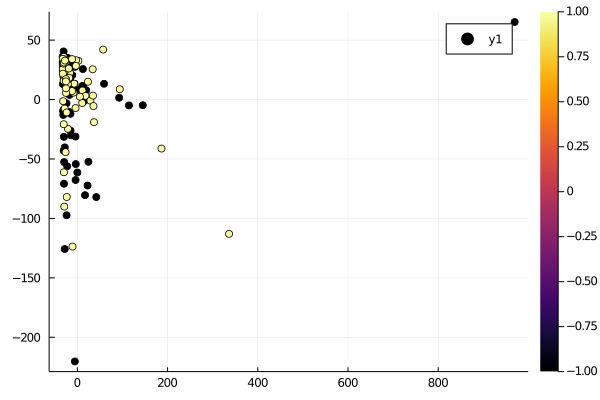

In [104]:
V = Vty';
PCS = V[:,1:2];
PCA = Y*PCS

plot(PCA[:,1], PCA[:,2],
     markershape = :circle,
     linealpha = 0.0, 
     marker_z = y)

## Categorization via PCA + NLS

In [109]:
Π_y = NLS(Vty, 10);
s = sortperm(Π_y, rev=true)[1:5]
Y = Y[:,[1;7237]];
SVD = svd(Y, full=false)
Uy = SVD.U;
Sy = diagm(SVD.S);
Vty = SVD.Vt;

LoadError: BoundsError: attempt to access 139×5 Array{Float64,2} at index [1:139, [1, 7237]]

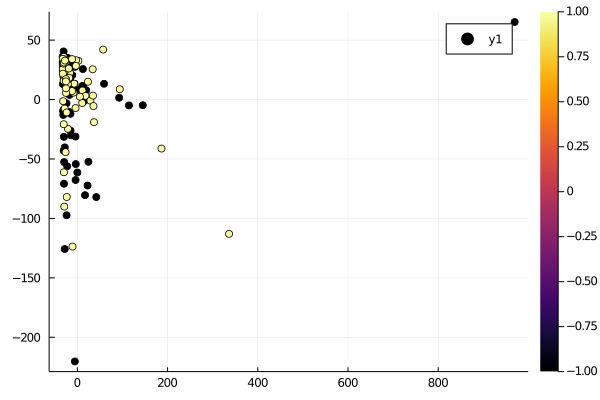

In [103]:
V = Float64.(Vty');
PCS = V[:,1:2];
PCA = Y*PCS

plot(PCA[:,1], PCA[:,2],
     markershape = :circle,
     linealpha = 0.0, 
     marker_z = y)

In [128]:
t = @elapsed for i =1:10
    println(i)
    end;


1
2
3
4
5
6
7
8
9
10


139×18446 Array{Float64,2}:
 54.0  11.0  53.0  22.0  44.0  2.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2.0   0.0   0.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  6.0   0.0   0.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 62.0   0.0   2.0   0.0   0.0  2.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 11.0   0.0   0.0   0.0   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 14.0   0.0   1.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 12.0   0.0   0.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0   0.0   0.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 20.0   0.0   0.0   0.0   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2.0   0.0   1.0   0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2.0   0.0   0.0   0.0   0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                    